In [107]:
import numpy as np
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from enum import Enum
import matplotlib as mpl
import geopandas as gpd
from tqdm import tqdm_notebook as tqdm
from operator import itemgetter
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [2]:
raw_NDVI_input = np.load("raw_NDVI_input.npy")
raw_NDWI_input = np.load("raw_NDWI_input.npy")
inpatches = np.load("FullInput.npy")
outpatches = np.load("FullOutput.npy")

In [3]:
class LULC(Enum):
    NO_DATA            = (0,  'No Data',            'white')
    CULTIVATED_LAND    = (1,  'Cultivated Land',    'xkcd:lime')
    FOREST             = (2,  'Forest',             'xkcd:darkgreen')
    GRASSLAND          = (3,  'Grassland',          'orange')
    SHRUBLAND          = (4,  'Shrubland',          'xkcd:tan')
    WATER              = (5,  'Water',              'xkcd:azure')
    WETLAND            = (6,  'Wetlands',           'xkcd:lightblue')
    TUNDRA             = (7,  'Tundra',             'xkcd:lavender')
    ARTIFICIAL_SURFACE = (8,  'Artificial Surface', 'crimson')
    BARELAND           = (9,  'Bareland',           'xkcd:beige')
    SNOW_AND_ICE       = (10, 'Snow and Ice',       'black')

    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3

# example usecase
# LULC.BARELAND.id   # return 9

# Reference colormap things
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 11, 1), lulc_cmap.N)

In [12]:
def patch_selector(inputlist):
    new_list = []
    for patch in inputlist:
        temp = patch
        tempin = np.array(itemgetter(0,3,8,9,11,17)(temp))
        new_list.append(tempin)
    return new_list

In [17]:
#CALCULATING EVI
def evi_small(image):
    evi_small_list = []
    for row in image:
        for px in row: 
            band_a = px[3]
            band_b = px[2]
            band_c = px[0]
            EVI = 2.5 * (band_a - band_b) / ((band_a + 6.0 * band_b - 7.5 * band_c) + 1.0)
            evi_small_list.append(EVI) 
    evi_small_array = np.array(evi_small_list).reshape(337, 333, 1)
    evi_small_array = evi_small_array.astype("float32")
    return evi_small_array


def evi_large(image_list):
    patches = [] #9 in total when finished
    for patch in image_list:
        images = [] #6 in total when finished
        for image in patch:
            small_array = evi_small(image)
            images.append(small_array)
        patches.append(images)
    return patches
        
            

In [8]:
rgb_input = []
for patch in inpatches:
    temp = patch
    tempin = itemgetter(0,3,8,9,11,17)(temp)
    done = np.delete(tempin, [3,4,5], 3)
    rgb_input.append(done)


In [74]:
NDVI_input = np.array(patch_selector(raw_NDVI_input))
NDWI_input = np.array(patch_selector(raw_NDWI_input))
temp_raw_evi = patch_selector(inpatches)

In [75]:
EVI_input = np.array(evi_large(temp_raw_evi))

In [19]:
temp_raw_evi[0][0][0][0]

array([0.1006, 0.0668, 0.0438, 0.0784, 0.0444, 0.0237], dtype=float32)

In [21]:
EVI_input[0][0][0][0]

array([0.1474348], dtype=float32)

In [28]:
def test_set_gen():
    test_rgb = []
    test_ndvi = []
    test_ndwi = []
    raw_test_evi = []
    test_set = []
    for patch in raw_NDVI_input:
        temp = patch
        tempin = np.array(itemgetter(25)(temp))
        test_ndvi.append(tempin)
    for patch in raw_NDWI_input:
        temp = patch
        tempin = np.array(itemgetter(25)(temp))
        test_ndwi.append(tempin)
    for patch in inpatches:
        temp = patch
        tempin = np.array(itemgetter(25)(temp))
        raw_test_evi.append(tempin)
    test_evi = evi_large(np.array(raw_test_evi).reshape(9, 1, 337, 333, 6))   
    for i in range(9):
        test_rgb.append(np.delete(inpatches[i][25], [3,4,5], 2))
    

    for i in range(9):
        patch_with_images = np.concatenate((np.array(test_rgb[i]).reshape(1, 337, 333, 3),
                  np.array(test_ndvi[i]).reshape(1, 337, 333, 1),
                  np.array(test_ndwi[i]).reshape(1, 337, 333, 1), np.array(test_evi[i]).reshape(1, 337, 333, 1)), axis=3)
        test_set.append(patch_with_images)
    return test_set
        

In [62]:
test_set = np.array(test_set_gen())

In [68]:
test_set[0, 0, :, :, :3].shape

(337, 333, 3)

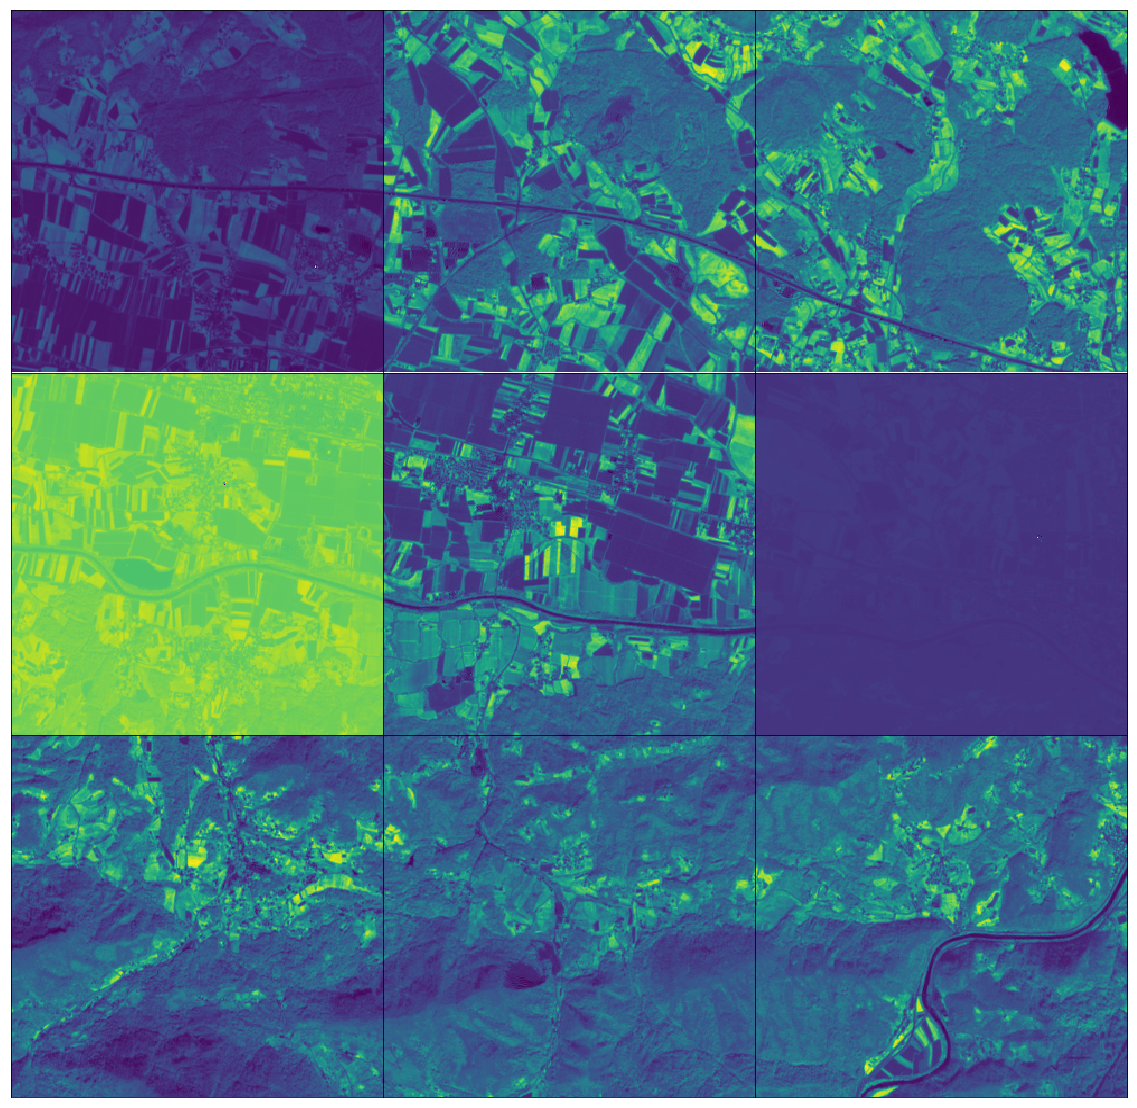

In [101]:
fig = plt.figure(figsize=(20, 20 * 1))

pbar = tqdm(total=9)
for i in range(9):
    eopatch = dataset_large[i, 3, :, :, 5] ####### SLIKA IZRAČUNANA ZA EVI #####
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(eopatch.squeeze())
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

In [77]:
## MACRO CLASSIFICATION for RGB, NDVI, NDWI, EVI
dataset_large = []
for i in range(9):
    patch_with_images = np.concatenate((rgb_input[i],
              NDVI_input[i], NDWI_input[i],
              EVI_input[i]), axis=3)
    dataset_large.append(patch_with_images)
dataset_large = np.array(dataset_large)

In [118]:
xlmlp = MLPClassifier(warm_start=True, learning_rate="adaptive", activation="relu", solver="adam", max_iter=500)
for i in range(9):
    xlmlp.fit(dataset_large[i, 0].reshape(112221, 6), outpatches[i].reshape(112221))

for i in range(9):
    print(xlmlp.score(test_set[i].reshape(112221, 6), outpatches[i].reshape(112221)))

0.5189492162785931
0.494978658183406
0.6583348927562578
0.46807638499033155
0.38490122169647395
0.6174958341130448
0.7197048680728206
0.8107217009294161
0.761435025529981


In [119]:
predictions = []
for i in range(9):
    prediction = xlmlp.predict(test_set[i].reshape(112221, 6))
    predictions.append(prediction)

control = []
for i in range(9):
    y = xlmlp.predict(dataset_large[i, 3].reshape(112221, 6))
    control.append(y)


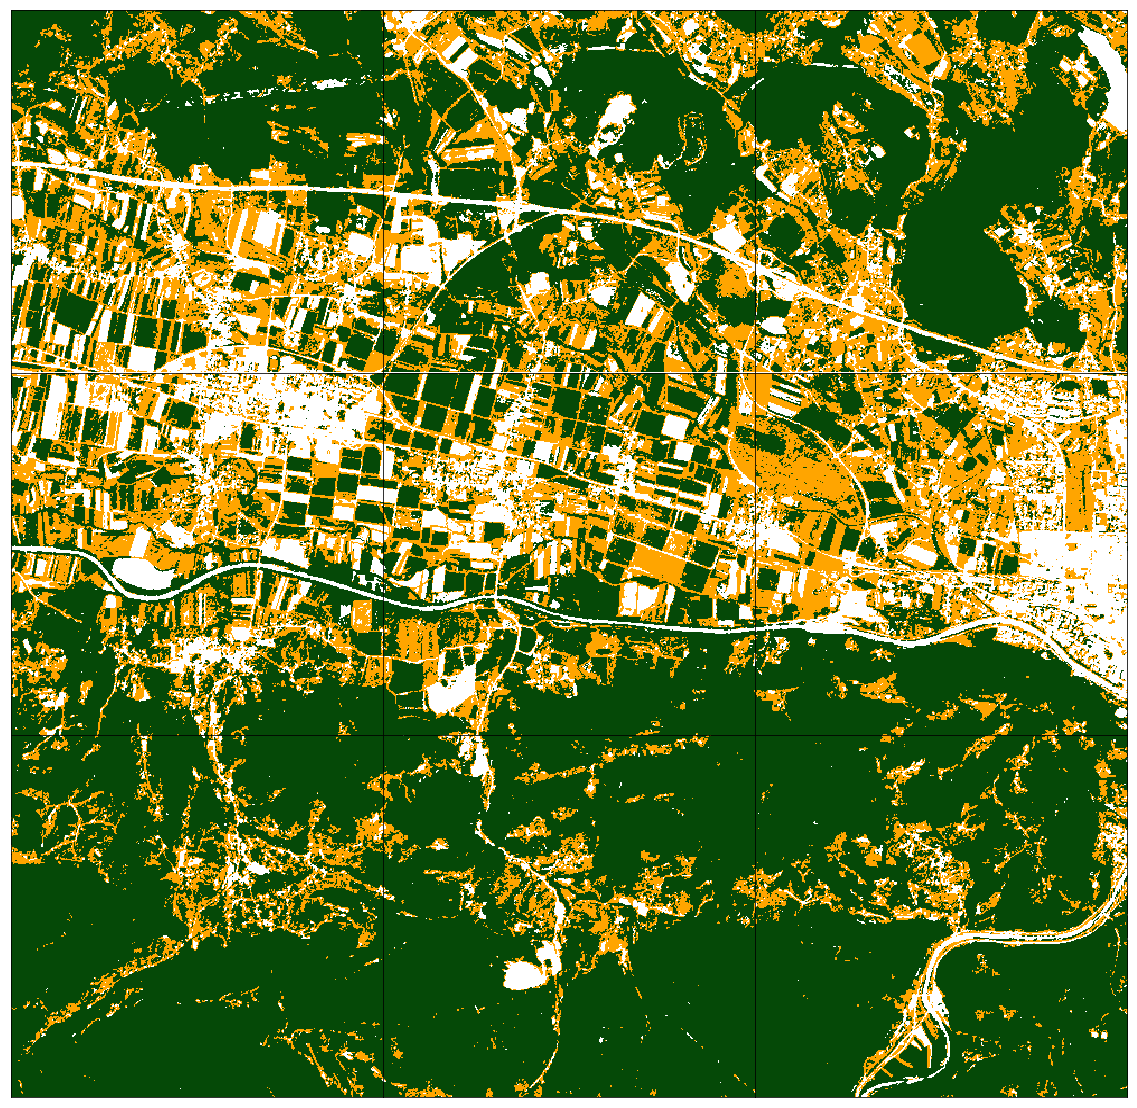

In [122]:
fig = plt.figure(figsize=(20, 20 * 1))

pbar = tqdm(total=9)
for i in range(9):
    eopatch = predictions[i].reshape(337, 333, 1)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(eopatch.squeeze(), cmap=lulc_cmap, norm=lulc_norm)
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

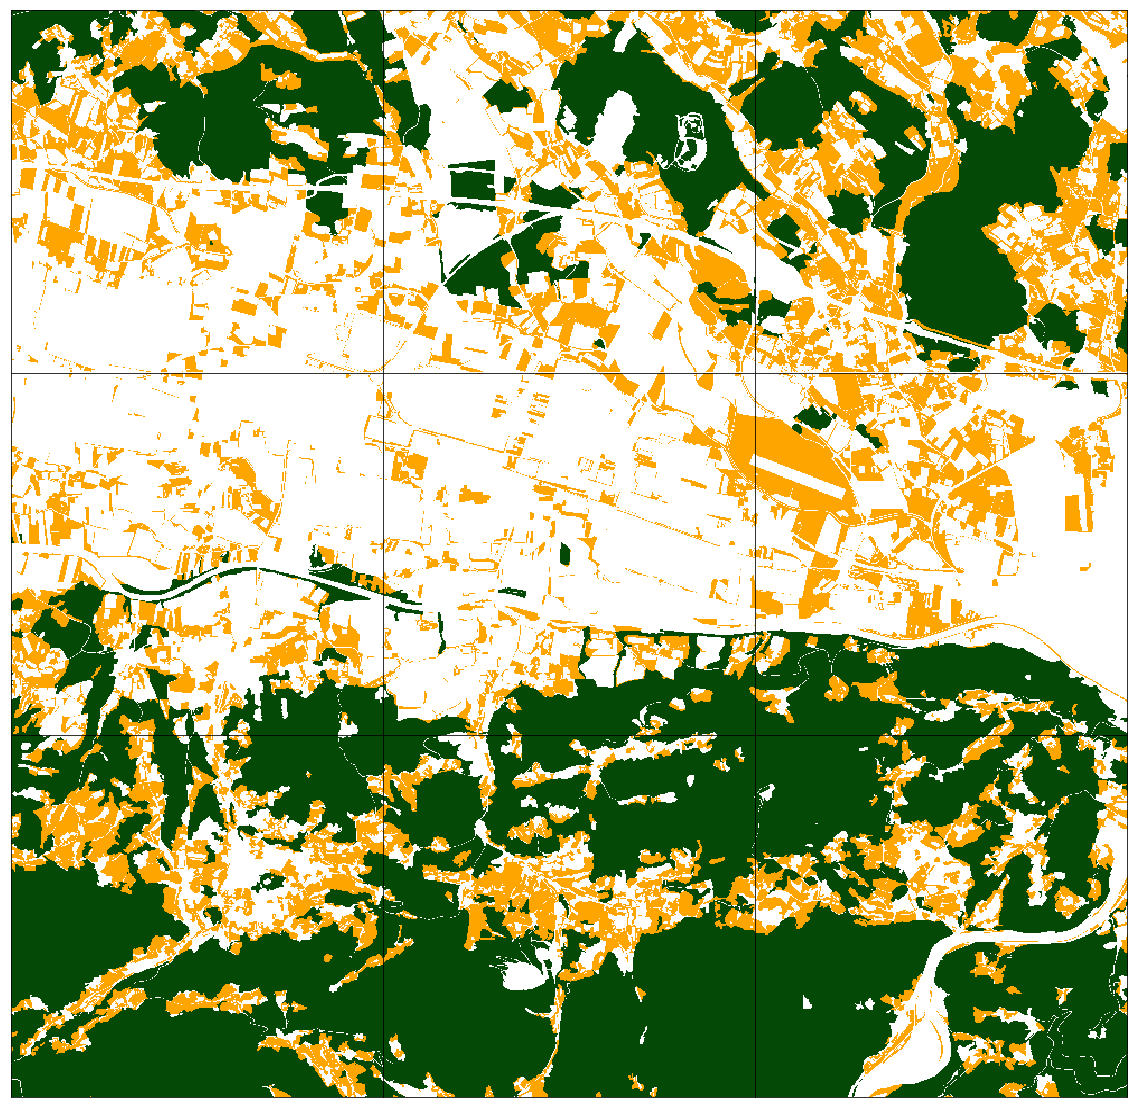

In [88]:
fig = plt.figure(figsize=(20, 20 * 1))

pbar = tqdm(total=9)
for i in range(9):
    eopatch = outpatches[i]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(eopatch.squeeze(), cmap=lulc_cmap, norm=lulc_norm)
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

In [123]:
for i in range(9):
    class_labels = [0, 2, 3]
    class_names = [entry.class_name for entry in LULC]

    f1_scores = metrics.f1_score(outpatches[i].reshape(112221, 1), predictions[i], labels=class_labels, average=None)
    recall = metrics.recall_score(outpatches[i].reshape(112221, 1), predictions[i], labels=class_labels, average=None)
    precision = metrics.precision_score(outpatches[i].reshape(112221, 1), predictions[i], labels=class_labels, average=None)

    print(f'        {i}   Class            =  F1  | Recall | Precision')
    print('         --------------------------------------------------')
    for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
        print('         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}'.format(lulctype,
                                                                             f1_scores[idx] * 100,
                                                                             recall[idx] * 100,
                                                                             precision[idx] * 100))

        0   Class            =  F1  | Recall | Precision
         --------------------------------------------------
         * No Data              = 46.0 |  30.6  | 92.6
         * Forest               = 63.5 |  97.4  | 47.1
         * Grassland            = 42.2 |  50.3  | 36.3
        1   Class            =  F1  | Recall | Precision
         --------------------------------------------------
         * No Data              = 40.5 |  26.4  | 87.3
         * Forest               = 57.6 |  98.0  | 40.7
         * Grassland            = 49.4 |  54.6  | 45.0
        2   Class            =  F1  | Recall | Precision
         --------------------------------------------------
         * No Data              = 46.1 |  32.2  | 80.9
         * Forest               = 78.0 |  99.0  | 64.4
         * Grassland            = 59.0 |  55.8  | 62.7
        3   Class            =  F1  | Recall | Precision
         --------------------------------------------------
         * No Data              = 51.